In [1]:
import os
import pandas as pd

In [ ]:
folders = ["data", "notebooks", "models"]
for f in folders:
    os.makedirs("/content/drive/MyDrive/Recommender_Project/"+f, exist_ok=True)

In [2]:
orders = pd.read_csv("/content/drive/MyDrive/Recommender_Project/data/orders.csv")
departments = pd.read_csv("/content/drive/MyDrive/Recommender_Project/data/departments.csv")
aisles = pd.read_csv("/content/drive/MyDrive/Recommender_Project/data/aisles.csv")
products = pd.read_csv("/content/drive/MyDrive/Recommender_Project/data/products.csv")
orders_products_prior = pd.read_csv("/content/drive/MyDrive/Recommender_Project/data/order_products__prior.csv")
orders_products_train = pd.read_csv("/content/drive/MyDrive/Recommender_Project/data/order_products__train.csv")

In [3]:
dfs = {
    "orders": orders,
    "departments": departments,
    "products": products,
    "aisles": aisles,
    "orders_products_prior": orders_products_prior,
    "orders_products_train": orders_products_train
}

In [4]:
for name, df in dfs.items():
  print(f"{name} : {df.shape}")

orders : (3421083, 7)
departments : (21, 2)
products : (49688, 4)
aisles : (134, 2)
orders_products_prior : (32434489, 4)
orders_products_train : (1384617, 4)


In [5]:
(orders.head())

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
orders_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
# Unique counts
print("\nUnique users:", orders['user_id'].nunique())
print("Unique products:", products['product_id'].nunique())
print("Unique aisles:", aisles['aisle_id'].nunique())
print("Unique departments:", departments['department_id'].nunique())


Unique users: 206209
Unique products: 49688
Unique aisles: 134
Unique departments: 21


In [9]:
# Quick product frequency check
top_products = orders_products_prior['product_id'].value_counts().head(10)
print("\nTop 10 most purchased product IDs:\n", top_products)


Top 10 most purchased product IDs:
 product_id
24852    472565
13176    379450
21137    264683
21903    241921
47209    213584
47766    176815
47626    152657
16797    142951
26209    140627
27845    137905
Name: count, dtype: int64


In [10]:
# Merge products with top counts for readability
top_products_named = pd.DataFrame({
    "product_id": top_products.index,
    "count": top_products.values
}).merge(products, on="product_id", how="left")

print("\nTop 10 most purchased products:\n", top_products_named[['product_id','product_name','count']])


Top 10 most purchased products:
    product_id            product_name   count
0       24852                  Banana  472565
1       13176  Bag of Organic Bananas  379450
2       21137    Organic Strawberries  264683
3       21903    Organic Baby Spinach  241921
4       47209    Organic Hass Avocado  213584
5       47766         Organic Avocado  176815
6       47626             Large Lemon  152657
7       16797            Strawberries  142951
8       26209                   Limes  140627
9       27845      Organic Whole Milk  137905


In [11]:
import numpy as np

# --- pick top-N most active users ---
user_order_counts = orders['user_id'].value_counts()
top_users = user_order_counts.head(10000).index   # top 10k users
orders_small = orders[orders['user_id'].isin(top_users)]

# --- restrict order-product pairs to these orders ---
order_ids_small = orders_small['order_id']
op_small = orders_products_prior[orders_products_prior['order_id'].isin(order_ids_small)]

# --- pick top-M most popular products ---
product_counts = op_small['product_id'].value_counts()
top_products = product_counts.head(20000).index    # top 5k products
op_small = op_small[op_small['product_id'].isin(top_products)]

# --- update orders_small again (drop orders with no remaining products) ---
order_ids_small = op_small['order_id'].unique()
orders_small = orders_small[orders_small['order_id'].isin(order_ids_small)]

# --- filter product metadata ---
products_small = products[products['product_id'].isin(top_products)]

print("Subset shapes:")
print("Orders:", orders_small.shape)
print("Order-Products:", op_small.shape)
print("Products:", products_small.shape)
print("Users:", orders_small['user_id'].nunique())
print("Products:", products_small['product_id'].nunique())

# --- save subset to disk ---
orders_small.to_csv("/content/drive/MyDrive/Recommender_Project/data/orders_small.csv", index=False)
op_small.to_csv("/content/drive/MyDrive/Recommender_Project/data/order_products_small.csv", index=False)
products_small.to_csv("/content/drive/MyDrive/Recommender_Project/data/products_small.csv", index=False)


Subset shapes:
Orders: (704816, 7)
Order-Products: (6764323, 4)
Products: (20000, 4)
Users: 10000
Products: 20000


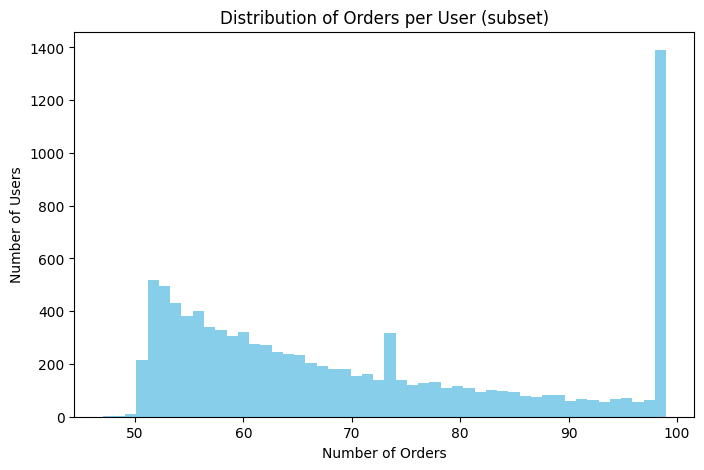

Average orders per user: 70.4816
Median orders per user: 65.0


In [12]:
import matplotlib.pyplot as plt

orders_per_user = orders_small.groupby('user_id')['order_id'].nunique()

plt.figure(figsize=(8,5))
plt.hist(orders_per_user, bins=50, color="skyblue")
plt.title("Distribution of Orders per User (subset)")
plt.xlabel("Number of Orders")
plt.ylabel("Number of Users")
plt.show()

print("Average orders per user:", orders_per_user.mean())
print("Median orders per user:", orders_per_user.median())


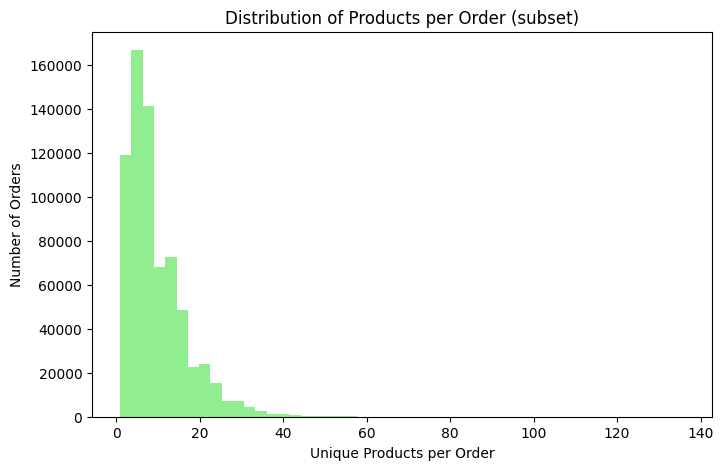

Average products per order: 9.597289221584074
Median products per order: 8.0


In [13]:
products_per_order = op_small.groupby('order_id')['product_id'].nunique()

plt.figure(figsize=(8,5))
plt.hist(products_per_order, bins=50, color="lightgreen")
plt.title("Distribution of Products per Order (subset)")
plt.xlabel("Unique Products per Order")
plt.ylabel("Number of Orders")
plt.show()

print("Average products per order:", products_per_order.mean())
print("Median products per order:", products_per_order.median())


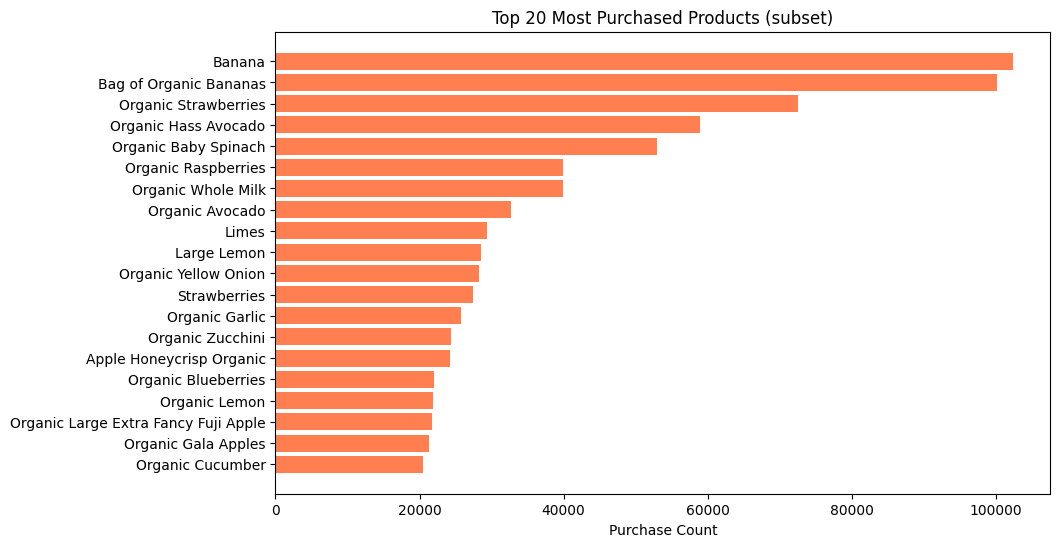

In [14]:
top20 = op_small['product_id'].value_counts().head(20).reset_index()
top20.columns = ['product_id', 'count']
top20 = top20.merge(products_small, on='product_id', how='left')

plt.figure(figsize=(10,6))
plt.barh(top20['product_name'], top20['count'], color="coral")
plt.gca().invert_yaxis()
plt.title("Top 20 Most Purchased Products (subset)")
plt.xlabel("Purchase Count")
plt.show()


In [15]:
example_user = orders_small['user_id'].sample(1).iloc[0]
user_orders = orders_small[orders_small['user_id']==example_user]['order_id']

user_products = op_small[op_small['order_id'].isin(user_orders)]
user_products_named = user_products.merge(products_small, on='product_id', how='left')

print(f"\nExample user {example_user} purchased:")
print(user_products_named[['order_id','product_name']].head(20))



Example user 94339 purchased:
    order_id               product_name
0      18128              Hass Avocados
1      18128  Seedless Small Watermelon
2      18128             Romaine Hearts
3      18128    Sleeve of Tuscan Melons
4      66952              Hass Avocados
5     102365  Seedless Small Watermelon
6     155384             Romaine Hearts
7     155384           Red Plastic Cups
8     155384   Heavy Duty Aluminum Foil
9     156256    Sleeve of Tuscan Melons
10    156256             Honeydew Melon
11    156256           Golden Pineapple
12    156256  Seedless Small Watermelon
13    188006             Romaine Hearts
14    188006              Hass Avocados
15    188006                 Canola Oil
16    201103             Romaine Hearts
17    201103              Hass Avocados
18    201103  Seedless Small Watermelon
19    201103             Honeydew Melon
